In [1]:
import pandas as pd
import numpy as np

import wrangle as w
import explore as e

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
np.random.seed(0)

from sklearn.metrics import mean_squared_error
from math import sqrt 


import warnings 
warnings.filterwarnings('ignore')

In [2]:
mon_sa = w.sales('monthly_home_sales_sa.csv')
mon_aus = w.sales('monthly_aus.csv')
mon_dal = w.sales('monthly_dal.csv')
mon_hou = w.sales('monthly_hou.csv')

In [3]:
df = e.comparing_markets(mon_sa,mon_aus,mon_dal, mon_hou, keys=['san antonio', 'austin', 'dallas', 'houston'])

In [4]:
mon_aus

,sales,dollar_volume,average_price,median_price,total_listings,months_inventory
date,,,,,,
1990-01-01,558,46937286,84117,71000,4391,7.9
1990-02-01,444,37056240,83460,71199,4343,8.7
1990-03-01,431,34722653,80563,72497,4459,9.3
1990-04-01,569,34616822,60838,71998,4545,9.1
1990-05-01,549,44907102,81798,73694,4731,9.3
...,...,...,...,...,...,...
2022-11-01,2055,1183522245,575923,464000,8738,3.0
2022-12-01,2508,1384506103,552036,450000,7416,2.6
2023-01-01,1630,907597030,556808,449990,7243,2.6


In [5]:
df

,san antonio,austin,dallas,houston
date,,,,
1990-01-01,73352,84117,105280,85771
1990-02-01,75637,83460,106998,88640
1990-03-01,81494,80563,104479,86125
1990-04-01,89849,60838,106941,90907
1990-05-01,90087,81798,111997,86045
...,...,...,...,...
2022-11-01,367292,575923,474614,399020
2022-12-01,373319,552036,454773,404350
2023-01-01,365480,556808,457712,378553


## Split Data

In [6]:
def split_data_explore(df):
    '''
    This function takes in a clean df and splits it to train, validate, and test to model upon
    '''
    train_size = int(round(df.shape[0] * 0.5))
    validate_size = int(round(df.shape[0] * 0.3))
    test_size = int(round(df.shape[0] * 0.2))
    
    
    validate_end_index = train_size + validate_size
    
    train = df[:train_size]
    validate = df[train_size:validate_end_index]
    test = df[validate_end_index:]

    
    return train, validate, test

In [7]:
train, validate, test = split_data_explore(df)

In [8]:
train.shape, validate.shape, test.shape

((200, 4), (120, 4), (79, 4))

In [9]:
train

,san antonio,austin,dallas,houston
date,,,,
1990-01-01,73352,84117,105280,85771
1990-02-01,75637,83460,106998,88640
1990-03-01,81494,80563,104479,86125
1990-04-01,89849,60838,106941,90907
1990-05-01,90087,81798,111997,86045
...,...,...,...,...
2006-04-01,163254,226997,189590,192849
2006-05-01,171978,228908,204039,200981
2006-06-01,177577,234463,206188,210126


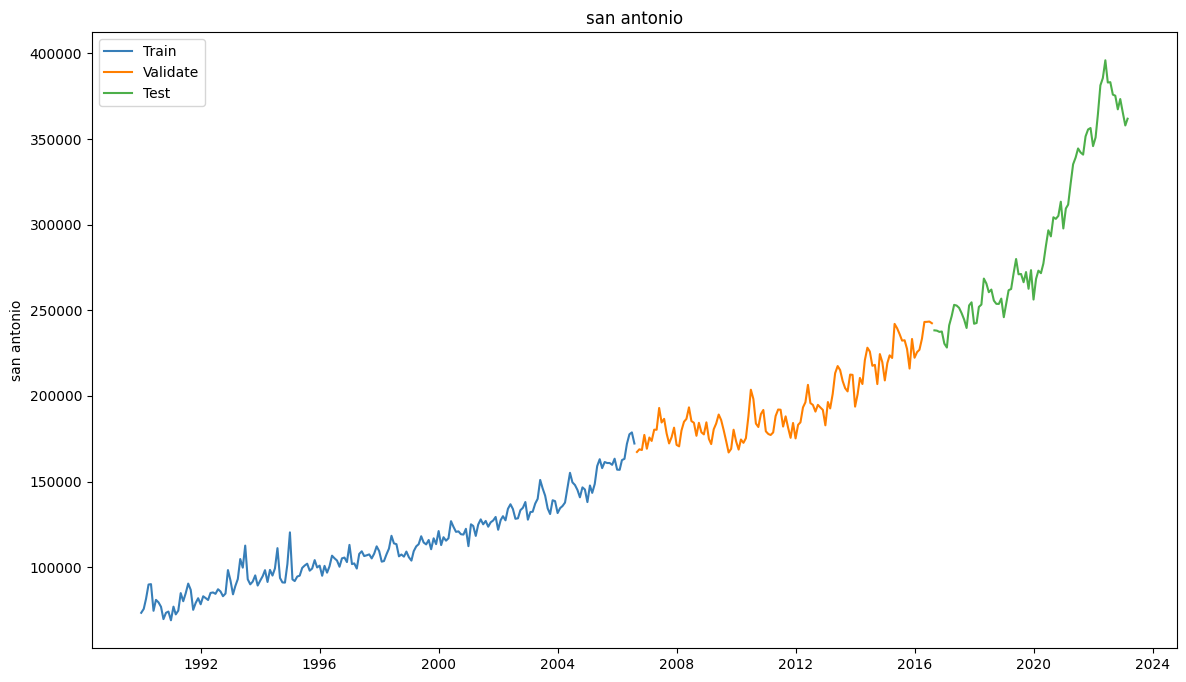

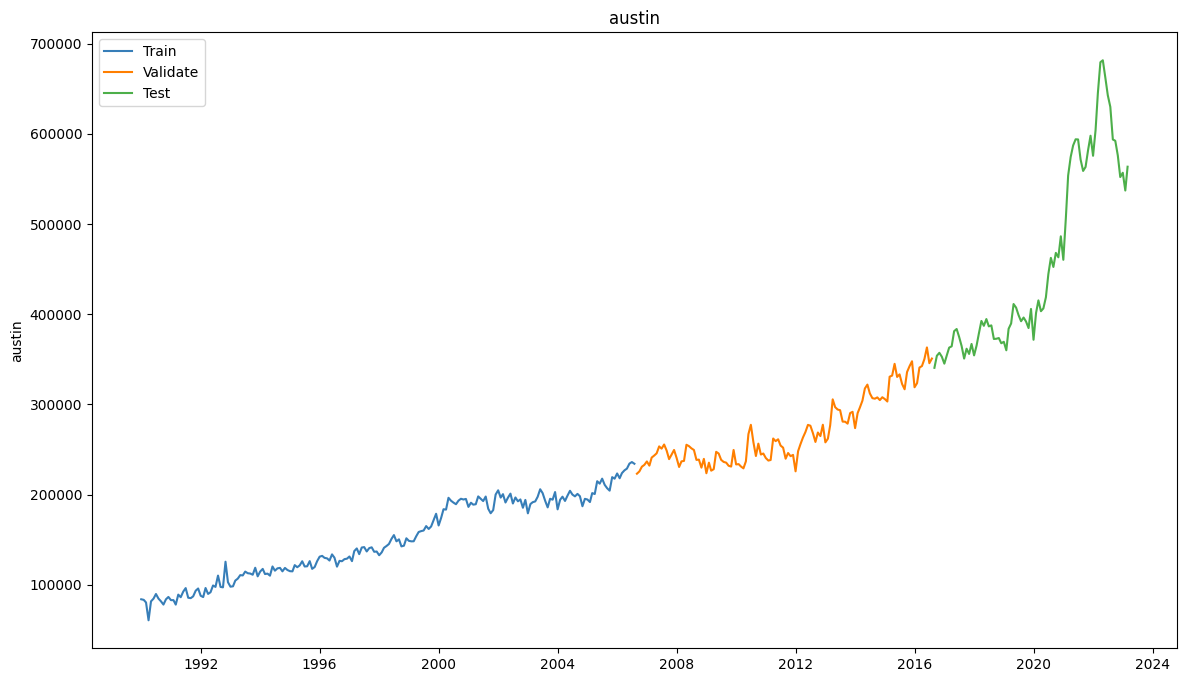

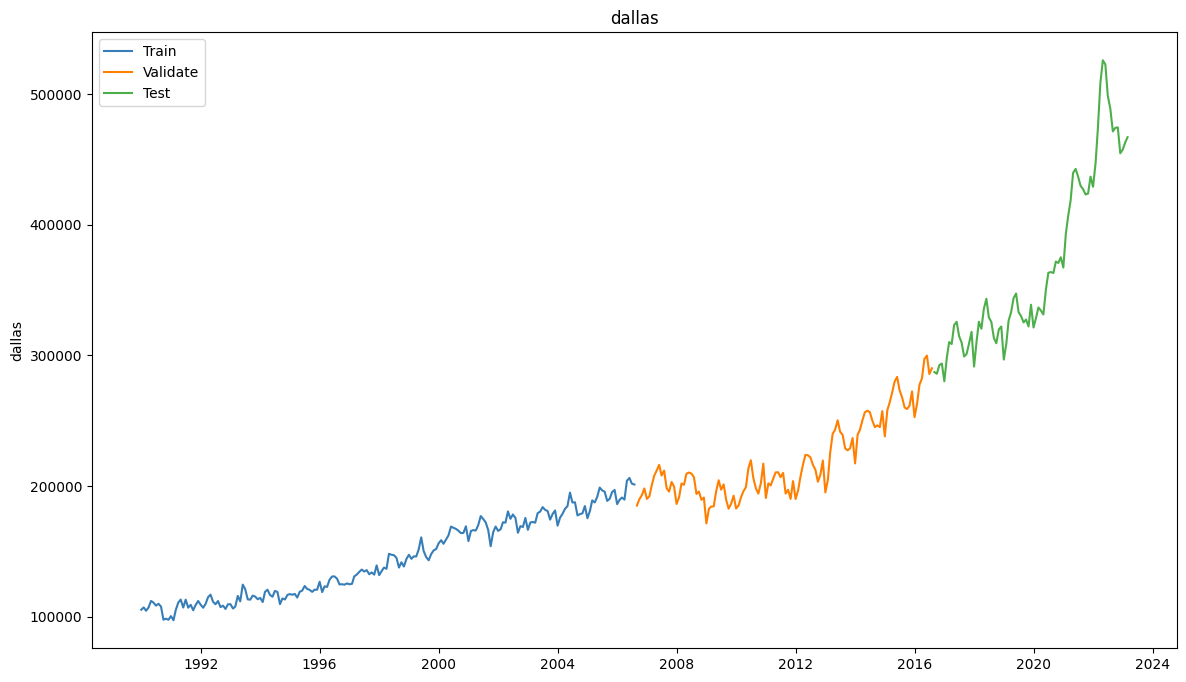

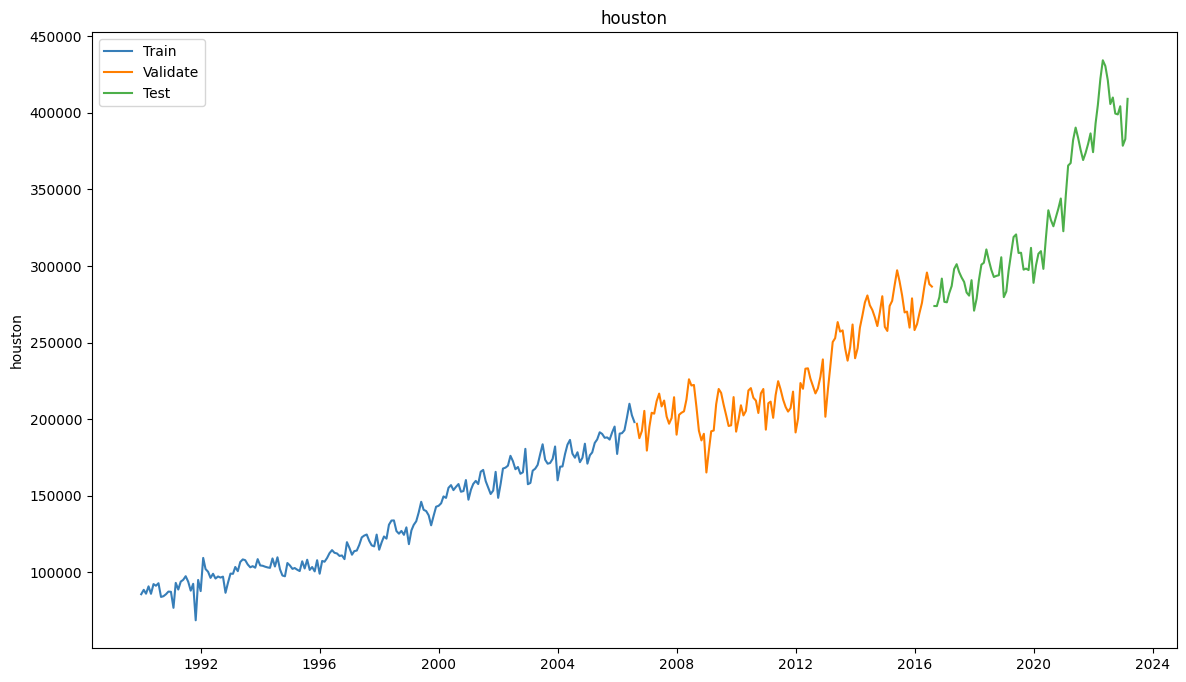

In [10]:
# Viz our train dataset
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col], color='#377eb8', label = 'Train')
    plt.plot(validate[col], color='#ff7f00', label = 'Validate')
    plt.plot(test[col], color='#4daf4a', label = 'Test')
    plt.legend()
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [11]:
# creating our baseline 
period=30
train['san antonio'].rolling(period).mean()

date
1990-01-01              NaN
1990-02-01              NaN
1990-03-01              NaN
1990-04-01              NaN
1990-05-01              NaN
                  ...      
2006-04-01    149884.033333
2006-05-01    150981.033333
2006-06-01    152282.466667
2006-07-01    153851.766667
2006-08-01    155109.000000
Name: san antonio, Length: 200, dtype: float64

In [12]:
period=30
train['san antonio'].rolling(period).mean()[-1]

155109.0

In [13]:
# Saving the last 30 day moving average for each column
rolling_san_antonio = round(train['san antonio'].rolling(period).mean()[-1], 2)
rolling_austin = round(train['austin'].rolling(period).mean()[-1], 2)
rolling_dallas = round(train['dallas'].rolling(period).mean()[-1], 2)
rolling_houston = round(train['houston'].rolling(period).mean()[-1], 2)
print(rolling_san_antonio, rolling_austin, rolling_dallas, rolling_houston) 

155109.0 209825.77 189714.07 185681.6


In [14]:
def make_baseline_predictions(san_antonio_col=None, austin_col=None, dallas_col = None, houston_col = None):
    yhat_df = pd.DataFrame({'san antonio': [san_antonio_col],
                           'austin': [austin_col],
                           'dallas': [dallas_col],
                           'houston': [houston_col]},
                          index=validate.index)
    return yhat_df

In [46]:
yhat_df = make_baseline_predictions(rolling_san_antonio, rolling_austin, rolling_dallas, rolling_houston)
yhat_df.head()

,san antonio,austin,dallas,houston
date,,,,
2006-09-01,151728.78,206995.31,187547.75,183289.56
2006-10-01,151728.78,206995.31,187547.75,183289.56
2006-11-01,151728.78,206995.31,187547.75,183289.56
2006-12-01,151728.78,206995.31,187547.75,183289.56
2007-01-01,151728.78,206995.31,187547.75,183289.56


In [16]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [17]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1, color='#377eb8')
    plt.plot(validate[target_var], label='Validate', linewidth=1, color='#ff7f00')
    plt.plot(yhat_df[target_var], label='yhat', linewidth=2, color='#a65628')
    plt.legend()
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

san antonio -- RMSE: 45834


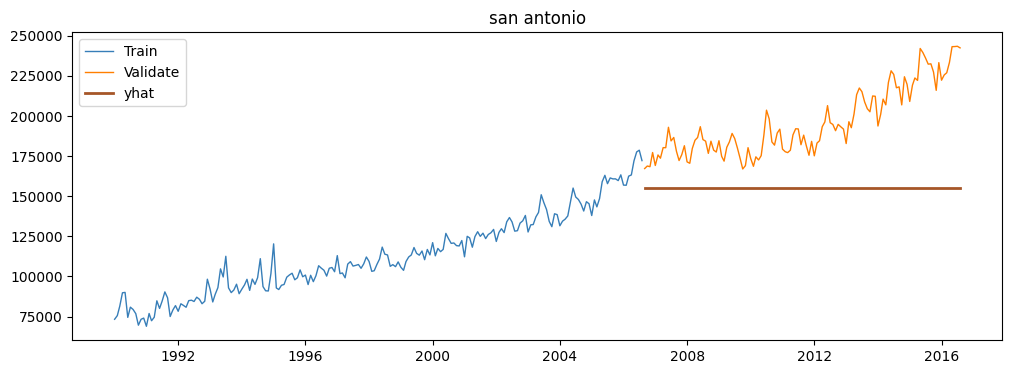

austin -- RMSE: 70937


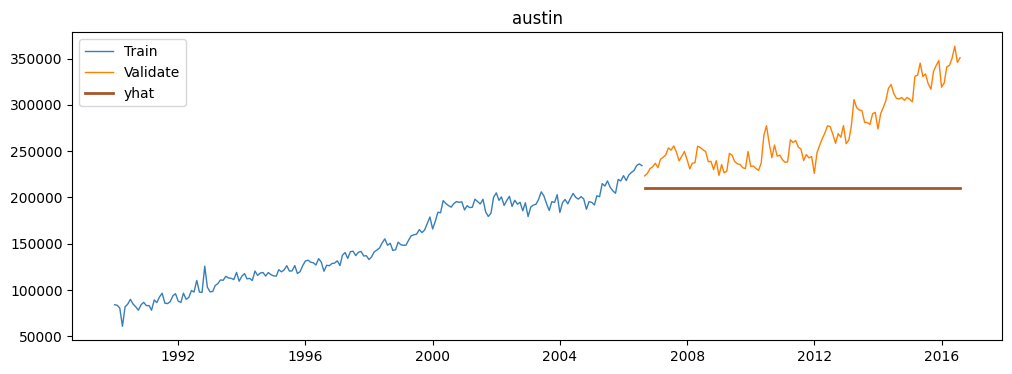

dallas -- RMSE: 42916


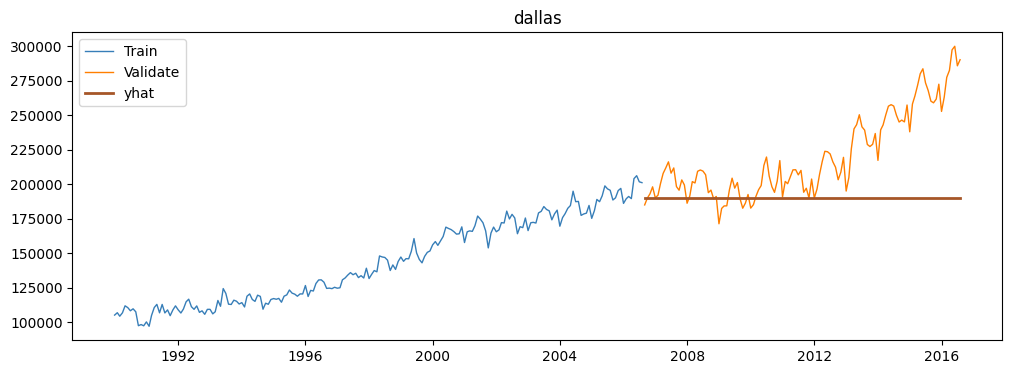

houston -- RMSE: 53406


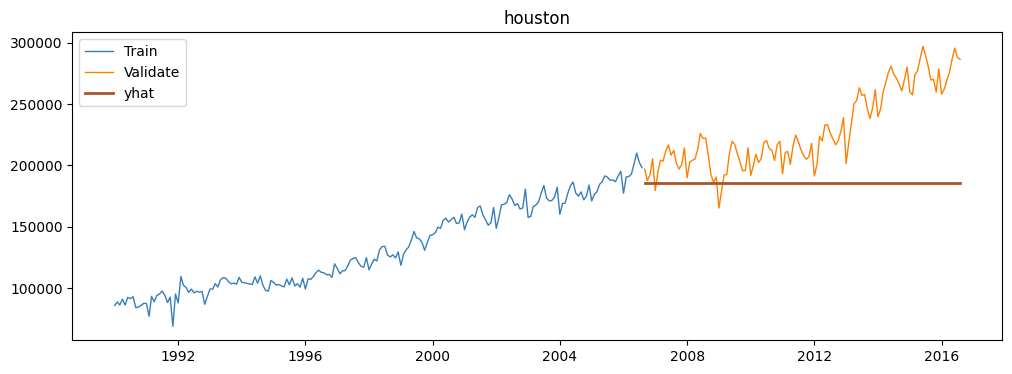

In [18]:
for col in train.columns:
    plot_and_eval(col)

In [19]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [20]:
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [21]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '1_qtr_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,1_qtr_avg,san antonio,45834.0
1,1_qtr_avg,austin,70937.0
2,1_qtr_avg,dallas,42916.0
3,1_qtr_avg,houston,53406.0


In [22]:
evaluate('san antonio')

45834.0

In [ ]:
periods= [1,3,6,9,12,18,24,36]
best_roll = []

for num in periods:
    
    yhat = train['san antonio'].rolling(num).mean()[-1]
    
    rmse = round(sqrt(mean_squared_error(validate['san antonio'], yhat_df['san antonio'])), 0)

    best_roll.append(rmse)
    
pd.DataFrame(best_roll)    
    
  

In [43]:
# this for loop is to make different rolling periods (within the periods stated)

best = []
for num in periods:  
    rolling_san_antonio = round(train['san antonio'].rolling(num).mean()[-1], 2)
    rolling_austin = round(train['austin'].rolling(num).mean()[-1], 2)
    rolling_dallas = round(train['dallas'].rolling(num).mean()[-1], 2)
    rolling_houston = round(train['houston'].rolling(num).mean()[-1], 2)
    
    best.append([rolling_san_antonio,rolling_austin, rolling_dallas, rolling_houston])

pd.DataFrame(best, columns=['san antonio', 'austin', 'dallas', 'houston'])  

,san antonio,austin,dallas,houston
0,172186.00,234305.00,201147.00,198169.00
1,176144.67,234984.67,203037.67,203642.00
2,171027.83,230802.17,198984.17,199274.33
3,167026.89,227148.00,196280.00,195430.89
4,165381.58,222949.67,195057.17,193767.58
5,162096.83,218549.83,194432.00,191376.00
6,157547.46,212595.92,190654.17,187569.00
7,151728.78,206995.31,187547.75,183289.56


In [44]:
yhat_df

,san antonio,austin,dallas,houston
date,,,,
2006-09-01,155109.0,209825.77,189714.07,185681.6
2006-10-01,155109.0,209825.77,189714.07,185681.6
2006-11-01,155109.0,209825.77,189714.07,185681.6
2006-12-01,155109.0,209825.77,189714.07,185681.6
2007-01-01,155109.0,209825.77,189714.07,185681.6
...,...,...,...,...
2016-04-01,155109.0,209825.77,189714.07,185681.6
2016-05-01,155109.0,209825.77,189714.07,185681.6
2016-06-01,155109.0,209825.77,189714.07,185681.6


In [73]:
rolling_san_antonio = round(train['san antonio'].rolling(3).mean()[-1], 2)
rolling_austin = round(train['austin'].rolling(3).mean()[-1], 2)

In [74]:
yhat_df = make_baseline_predictions(rolling_san_antonio, rolling_austin)
yhat_df

,san antonio,austin,dallas,houston
date,,,,
2006-09-01,176144.67,234984.67,None,None
2006-10-01,176144.67,234984.67,None,None
2006-11-01,176144.67,234984.67,None,None
2006-12-01,176144.67,234984.67,None,None
2007-01-01,176144.67,234984.67,None,None
...,...,...,...,...
2016-04-01,176144.67,234984.67,None,None
2016-05-01,176144.67,234984.67,None,None
2016-06-01,176144.67,234984.67,None,None


In [76]:
evaluate('austin')

51244.0

In [78]:
rolls = []   
for num in periods:    
    rolling_san_antonio = round(train['san antonio'].rolling(num).mean()[-1], 2)
    rolling_austin = round(train['austin'].rolling(num).mean()[-1], 2)
    
    yhat_df = make_baseline_predictions(rolling_san_antonio, rolling_austin)
    rmse = evaluate( 'austin')
    
    rolls.append(rmse)
    
pd.DataFrame(rolls)    

,0
0,51714.0
1,51244.0
2,54205.0
3,56918.0
4,60158.0
5,63673.0
6,68593.0
7,73362.0
